In [1]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [2]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using LuxDeviceUtils: cpu_device, gpu_device
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

Precompiling PhasorNetworks
  ✓ PhasorNetworks
  1 dependency successfully precompiled in 11 seconds. 412 already precompiled.


In [3]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [4]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [5]:
# solver_args = Dict(:adaptive => false, :dt => 0.01)

In [6]:
# spk_args = SpikingArgs(t_window = 0.01, 
#                     threshold = 0.001,
#                     solver=Heun(), 
#                     solver_args = solver_args)

In [7]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 10
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2])

@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 256    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
    rng::Xoshiro = Xoshiro(42) ## global rng
end

Args

In [8]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [9]:
function build_mlp(args)
    phasor_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), x -> x, PhasorDense(2 => 128), PhasorDense(128 => 2))
    ps, st = Lux.setup(args.rng, phasor_model)
    return phasor_model, ps, st
end

function build_spiking_mlp(args, spk_args)
    spk_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), MakeSpiking(spk_args, repeats), PhasorDense(2 => 128), PhasorDense(128 => 2))
    ps, st = Lux.setup(args.rng, spk_model)
    return spk_model, ps, st
end

build_spiking_mlp (generic function with 1 method)

In [72]:
import .PhasorNetworks: v_bundle_project, neuron_constant, spike_current, bias_current, gaussian_kernel, is_active

In [83]:
function bias_current(bias::AbstractArray, t::Real, t_offset::Real, spk_args::SpikingArgs; sigma::Real=9.0)
    #what times to the bias values correlate to?
    times = phase_to_time(complex_to_angle(bias), spk_args=spk_args, offset=t_offset)
    mag = abs.(bias)
    #determine the time within the cycle
    t = mod(t, spk_args.t_period)
    #determine which biases are active
    active = is_active(times, t, spk_args.t_window, sigma=sigma)

    #add the active currents, scaled by the gaussian kernel & bias magnitude
    current_kernel = x -> gaussian_kernel(x, t, spk_args.t_window)
    impulses = mag[active] .* current_kernel(times[active])

    bias = zeros(Float32, size(bias))
    bias[active] += impulses
    return bias
end

bias_current (generic function with 1 method)

In [99]:
function v_bundle_project(x::AbstractMatrix, w::AbstractMatrix, b::AbstractVecOrMat)
    xz = w * angle_to_complex(x) .+ b
    y = complex_to_angle(xz)
    return y
end

function v_bundle_project(x::SpikeTrain, w::AbstractMatrix, b::AbstractVecOrMat, tspan::Tuple{<:Real, <:Real}, spk_args::SpikingArgs; return_solution::Bool=false)
    #set up functions to define the neuron's differential equations
    k = neuron_constant(spk_args)
    #get the number of batches & output neurons
    output_shape = (size(w, 1), x.shape[2])
    u0 = zeros(ComplexF32, output_shape)
    dzdt(u, p, t) = k .* u + w * spike_current(x, t, spk_args) .+ bias_current(b, t, x.offset, spk_args)
    #solve the ODE over the given time span
    prob = ODEProblem(dzdt, u0, tspan)
    sol = solve(prob, spk_args.solver; spk_args.solver_args...)
    #option for early exit (mostly for debug)
    if return_solution return sol end

    #convert the full solution (potentials) to spikes
    train = solution_to_train(sol, tspan, spk_args = spk_args, offset = x.offset)
    next_call = SpikingCall(train, spk_args, tspan)
    return next_call
end


v_bundle_project (generic function with 3 methods)

In [85]:
args = Args()

Args(0.0003, 256, 10, false, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [86]:
train_loader, test_loader = getdata(args)
x, y = first(train_loader)

([0.4363590795046628 -0.020726939563912576 … -0.014802110970796872 -0.0019893102515646105; -0.17784306532747968 0.3038012525038328 … -0.07276908176492998 -0.005627426425963785], Bool[0 0 … 1 1; 1 1 … 0 0])

In [87]:
model, ps, st = build_mlp(args)

(Chain(), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[-0.09775257 -0.033171576; 0.020251632 0.0070170956; … ; 0.04797584 0.04434996; -0.002902955 0.14405486], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im  …  1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im]), layer_5 = (weight = Float32[-0.7682285 0.26694193 … 0.07480648 0.34993985; 0.15990366 -0.17788795 … -0.27716428 1.1225573], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [88]:
spk_model, _, _ = build_spiking_mlp(args, spk_args)

(Chain(), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[-0.09775257 -0.033171576; 0.020251632 0.0070170956; … ; 0.04797584 0.04434996; -0.002902955 0.14405486], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im  …  1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im]), layer_5 = (weight = Float32[-0.7682285 0.26694193 … 0.07480648 0.34993985; 0.15990366 -0.17788795 … -0.27716428 1.1225573], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [89]:
y, _ = model(x, ps, st)

([-0.0019285167537414077 -0.03241186931204119 … -0.04047898389028844 -0.022850388695367284; -0.003959956378755484 0.011284437669923856 … -0.002009810639792378 0.0010614035313016793], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [100]:
y_spk, _ = spk_model(x, ps, st)

(SpikingCall(Spike Train: (2, 256) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [101]:
y_spk.train.offset

0.5

In [102]:
p_spk = train_to_phase(y_spk);

In [103]:
size(p_spk)

(11, 2, 256)

In [104]:
size(y)

(2, 256)

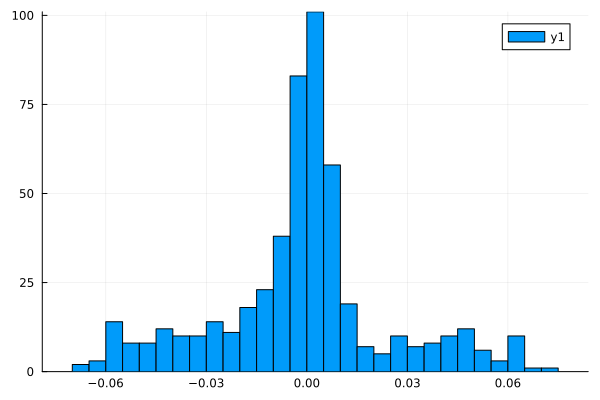

In [105]:
histogram(vec(p_spk[5,:,:]))

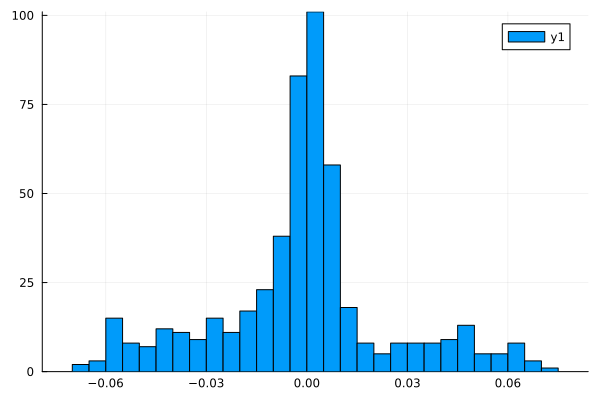

In [106]:
histogram(vec(p_spk[6,:,:]))

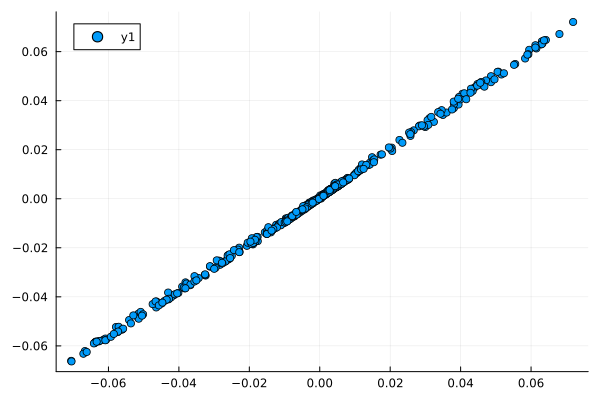

In [107]:
scatter(vec(y), vec(p_spk[5,:,:]))

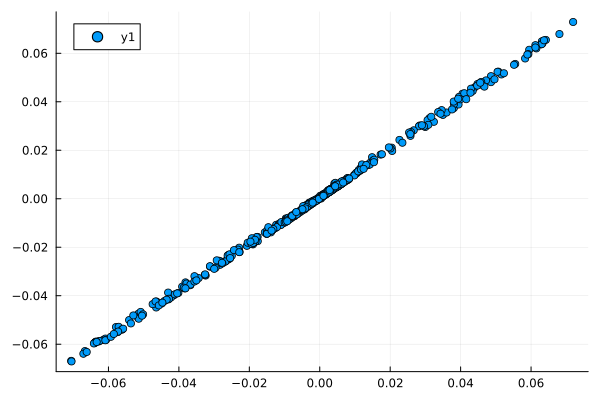

In [108]:
scatter(vec(y), vec(p_spk[6,:,:]))

In [109]:
y |> size

(2, 256)

In [110]:
p_spk |> size

(11, 2, 256)

In [111]:
cycle_correlation(y, p_spk)

11-element Vector{Float64}:
   0.0
 NaN
   0.999311512402804
   0.9993718016940433
   0.9993814054919319
   0.9993840522350808
   0.9993849159171225
   0.9993851768644928
   0.9993852071820913
   0.9993851494371482
   0.9804089144080536

In [112]:
losses, ps_train, st_train = train(model, ps, st, train_loader, args)

[ Info: Training on CPU


(Any[0.5098837885717605, 0.4853173373933747, 0.49141322971236934, 0.48693468551353625, 0.4954340023802486, 0.4933137356083457, 0.500454731585912, 0.5127275504546094, 0.49016137312372754, 0.5044012208641829  …  0.10231575128883391, 0.11467120780161658, 0.09981649078283104, 0.10328548609088986, 0.11305962855609131, 0.10541614197449292, 0.10952960779313718, 0.10779581678071644, 0.11196793010022738, 0.10054238837919939], (layer_1 = (bias = Float32[0.23439585; 0.2635558;;], scale = Float32[0.76594704; 0.84084374;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[-0.106405556 -0.05877709; 0.0275859 0.03325663; … ; 0.10580749 0.121909164; -0.013315139 0.13292493], bias = ComplexF32[0.9990795f0 - 0.024900991f0im, 0.99983144f0 - 0.003997041f0im, 0.9835712f0 + 0.11965799f0im, 1.0013616f0 - 0.023740752f0im, 1.0016284f0 + 0.043335535f0im, 0.9892998f0 + 0.08624818f0im, 0.99898785f0 + 0.020514678f0im, 1.0019913f0 - 0.0229097f0im, 0.9951203f0 + 0.06976279f0im, 1.0001307f

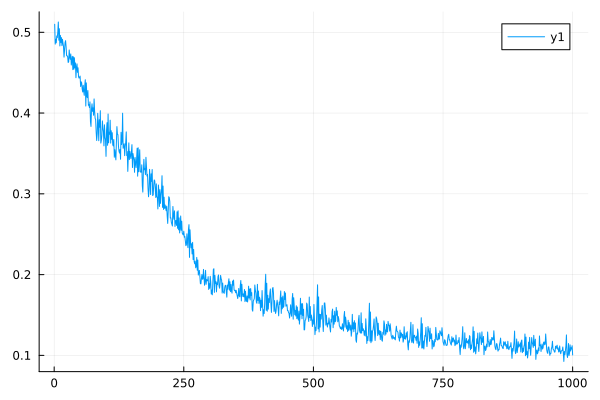

In [113]:
plot(losses)

In [114]:
loss_and_accuracy(test_loader, model, ps_train, st_train)

(0.10753725421911446, 0.980859375)

In [115]:
yt, _ = model(x, ps_train, st_train)

([0.010511147253316968 0.22561481740239878 … 0.3682564698021048 0.3624999659607059; 0.3239169318724967 0.29890080607483527 … 0.24609297370649486 0.0677778450961874], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [116]:
ps_train

(layer_1 = (bias = Float32[0.23439585; 0.2635558;;], scale = Float32[0.76594704; 0.84084374;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[-0.106405556 -0.05877709; 0.0275859 0.03325663; … ; 0.10580749 0.121909164; -0.013315139 0.13292493], bias = ComplexF32[0.9990795f0 - 0.024900991f0im, 0.99983144f0 - 0.003997041f0im, 0.9835712f0 + 0.11965799f0im, 1.0013616f0 - 0.023740752f0im, 1.0016284f0 + 0.043335535f0im, 0.9892998f0 + 0.08624818f0im, 0.99898785f0 + 0.020514678f0im, 1.0019913f0 - 0.0229097f0im, 0.9951203f0 + 0.06976279f0im, 1.0001307f0 + 0.0025988547f0im  …  0.9915388f0 + 0.10262845f0im, 0.98549837f0 + 0.102282375f0im, 0.99982315f0 + 0.025530713f0im, 0.9999535f0 - 0.01883501f0im, 0.99871475f0 + 0.04646318f0im, 0.9985661f0 - 0.08485727f0im, 0.9996472f0 + 0.0009730351f0im, 0.9993879f0 - 0.011076638f0im, 0.9958694f0 - 0.071211755f0im, 0.99900144f0 + 0.03326305f0im]), layer_5 = (weight = Float32[-0.81207204 0.22282109 … 0.038902648 0.30000323; 0.03212

In [117]:
yt_spk, _ = spk_model(x, ps_train, st_train)

(SpikingCall(Spike Train: (2, 256) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [118]:
pt = train_to_phase(yt_spk.train, spk_args=spk_args);

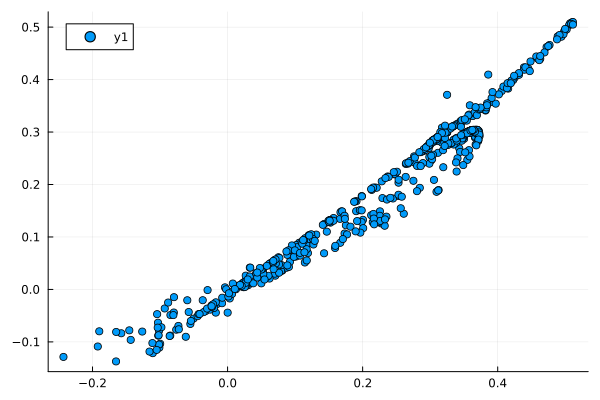

In [119]:
scatter(vec(yt), vec(pt[5,:,:]))

In [120]:
cycle_correlation(yt, pt)

11-element Vector{Float64}:
  0.0
 -0.12244859648512478
  0.9275647866482266
  0.9683908568470744
  0.9827317641716138
  0.9892250113410697
  0.9925710506215208
  0.99443308520284
  0.9955232941808044
  0.9961850546958612
  0.5923631547987349